# 06. Full Detector Validation and Demo

### Purpose:
This notebook includes the code to run a full end to end detection of bib numbers starting with a complete image.  This includes a first detection of the bib bounding box using the bib detection model which is then passed to the digit detector.  The detected digits are put in order from left to right based on their individual bounding boxes.  This process is run against set3 of the RBNR dataset which was not used to train either model, and the outputed bib numbers are compared against the true values provided in the dataset and compliled into a list in notebook 03.  Final conclusions are drawn from this validation, and then code is provided for demoing the full detector against an image, video file, or live video stream.

### Before Running Notebook:
1. Download the config file and weights file from Google Drive for the bib detection model.  These were created in the previous notebook (05_RBNR_YOLOv4_tiny_Darknet_Roboflow.ipynb).  Save them in ./Data/YOLO/bib_detector/ from the top level of this repo, and make sure they are set as the value of bd_configPath and bd_weightsPath below. 
1. Ensure that nr_configPath and nr_weightPath are the correct paths for the digit detector model files downloaded previously.
1. Create a folder named Full under Data/Validation/ for saving images and data for validation.

In [1]:
import cv2 as cv
import numpy as np
import scipy.io as sio
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
# Bib detection model config
bd_configPath = '../Data/YOLO/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = '../Data/YOLO/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']

# Number reader config
nr_configPath = '../Data/YOLO/num_reader/SVHN3_custom-yolov4-tiny-detector.cfg'
nr_weightsPath = '../Data/YOLO/num_reader/SVHN3_custom-yolov4-tiny-detector_best.weights'
nr_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# True bounding box color
true_color = [15, 252, 75]
# Pred Bib bounding box color
color = [252, 15, 192]

## Class and Function Definitions
---

In [3]:
class Detector:
    """
    Create YOLO object detection model in OpenCV with a given config and weights.
    Use this model to make predictions.
    
    Attributes
        classes (list): list of class names
        net (obj): openCV network object
        ln (obj): openCV layer names object
    """
    
    def __init__(self, cfg, wts, classes):
        """Initialize detector object
        
        Args
            cfg (str): path to model config file
            wts (str): path to model weights file
            classes (list): list of class names
        """
        
        self.classes = classes
        self.net = cv.dnn.readNetFromDarknet(cfg, wts)
        self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

        # determine the output layer
        self.ln = self.net.getLayerNames()
        self.ln = [self.ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        
    def detect(self, img, conf):
        """
        Make predictions and return classes and bounding boxes
        
        Args
            img (numpy array): image array from openCV .imread
            conf (float): prediction confidence threshold
            
        Returns
            List containing bounding box values and class names for detections
            in the form [<class name>, [x, y, width, height]]
        """
        
        #format image for detection
        blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
        
         # get detections
        self.net.setInput(blob)
        outputs = self.net.forward(self.ln)

        # initialize lists
        boxes = []
        confidences = []
        classIDs = []

        # initialize image dimensions
        h_img, w_img = img.shape[:2]

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # drop low confidence detections and 
                if confidence > conf:
                    box = detection[:4] * np.array([w_img, h_img, w_img, h_img])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    box = [x, y, int(width), int(height)]
                    boxes.append(box)
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # apply non maximal suppression for
        # initialize lists
        self.boxes = []
        self.confidences = []
        self.detected_classes = []
        cls_and_box = []
        # get indices of final bounding boxes  
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indices) > 0:
            for i in indices.flatten():
                self.boxes.append(boxes[i])
                self.confidences.append(confidences[i])
                self.detected_classes.append(self.classes[classIDs[i]])
                
                cls_and_box.append([self.classes[classIDs[i]], boxes[i]])
        
        return cls_and_box

In [4]:
def get_rbns(img, single=False):
    """
    Given an image return bib numbers and bib bounding boxes for detected bibs
    
    Args
        img (numpy array): image array given by openCV .imread
        single (bool): whether one or many bib detections will be
            returned.  If true, return detection with largest bounding
            box area.
            
    Returns
        List of detected bib numbers and corresponding bounding boxes in
        the format [<bib number>, [x, y, width, height]]
    """
    
    # Instantiate detectors
    bd = Detector(bd_configPath, bd_weightsPath, bd_classes)
    nr = Detector(nr_configPath, nr_weightsPath, nr_classes)

    # Make bib location predictions
    bib_detections = bd.detect(img, 0.25)


    if len(bib_detections) > 0:
        for obj in bib_detections:
            # crop out detected bib
            (x, y, w, h) = obj[1]
            obj.append(w * h)
            crop_img = img[y:y+h, x:x+w]
            
            # detect numbers on bib
            num_detections = nr.detect(crop_img, 0.5)
            bib_digit_loc = []
            if len(num_detections) > 0:
                # get digits and locations
                for digit in num_detections:
                    (d_x, d_y, d_w, d_h) = digit[1]
                    bib_digit_loc.append((d_x, str(digit[0])))

                # sort detected numbers L->R and put together
                bib_digit_loc.sort()
                rbn = int(''.join([i[1] for i in bib_digit_loc]))
                obj.append(rbn)
            else:
                obj.append(0) # bib detection but no digit detection

        if single: 
            if len(bib_detections) > 1:
                bib_detections.sort(key=lambda x: x[2], reverse=True)
            return [[bib_detections[0][3], bib_detections[0][1]]]
        else:
            final_bibs = []
            for bib in bib_detections:
                final_bibs.append([bib[3], bib[1]])
            return final_bibs
    else: return None

In [10]:
def annotate(img, annot, color):
    """
    Add bib numbers and bib bounding boxes to an image
    
    Args
        img (numpy array): image array of original from openCV .imread
        annot (list): list of bib numbers and bounding boxes in the 
            form [[<bib number>, [x, y, width, height]]]
        color (array): RGB color array for annotation color
        
    Returns
        Annotated image as numpy array
    """
    
    # draw bouding box on original image
    (x, y, w, h) = annot[1]
    annot_img = cv.rectangle(img,(x,y),(x+w,y+h),color,5)
    # add bib number to original image
    rbn = annot[0]
    cv.putText(annot_img, str(rbn), (x, y - 25), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    return annot_img

## Validation
---

### Predict

In [6]:
def get_true_annot(image, input_path, out_path):  
    """
    Read in the RBNR annotation file and return annotations
    
    Args
        image (str): name of original image
        input_path (str): path to directory of image
        out_path (str): directory where results are saved
        
    Returns
        List of annotations in format 
        [[<bib number>, [x, y, width, height]]]
    """
    
    # load annotation file
    f = sio.loadmat(input_path + image + '.mat')

    #get bounding boxes and bib numbers
    boxes = f['tagp']
    numbers = f['number'].flatten()

    bib_annots = []
    for i, box in enumerate(boxes):
        #convert box values to int
        (y1, y2, x1, x2) = [int(i) for i in box]
        
        # add rbn and formated bounding box to list
        bib_annots.append([numbers[i], [x1, y1, x2-x1, y2-y1]])
        
        # add true bib numbers to file
        true_file = open(out_path + 'bib_numbers.txt', 'a')
        true_file.writelines(f"{image},{numbers[i]}\n")
        true_file.close()
    
    return bib_annots

In [11]:
# set input and output info for detections
images_path = '../Data/RBNR/set3_org/'
images = [file for file in os.listdir(images_path) if file[-3:]=='JPG']

output_path = '../Data/Validation/Full/'

In [12]:
#check for existing bib_numbers.txt and remove if exists
if os.path.exists(output_path + 'bib_numbers.txt'):
    os.remove(output_path + 'bib_numbers.txt')

#check for existing preds.txt and remove if exists
if os.path.exists(output_path + 'preds.txt'):
    os.remove(output_path + 'preds.txt')

In [13]:
# run detections on all images in input directory
for image in images:
    img = cv.imread(images_path + image)
    
    # add true annotations
    true_values = get_true_annot(image, images_path, output_path)
    for value in true_values:
        annot_img = annotate(img, value, true_color)
    
    # make predictions
    output = get_rbns(img)
    
    # add predicted annotations and save prediction to file
    if output != None:
        rbn_file = open(output_path + 'preds.txt', 'a')
        
        for detection in output:
            annot_img = annotate(annot_img, detection, color)
            rbn_file.writelines(f"{image},{detection[0]}\n")
            
        rbn_file.close()
        
    # save annotated image to file
    cv.imwrite(output_path + image[:-4] + 'annot' + '.JPG', annot_img)

### Validate

In [16]:
true_df = pd.read_csv('../Data/Validation/Full/bib_numbers.txt', delimiter=',', 
                      index_col=0, names=['image', 'rbn'])
true_df.head()

,rbn
image,
set3_58.JPG,1880
set3_58.JPG,2813
set3_49.JPG,4606
set3_49.JPG,3591
set3_49.JPG,858


In [17]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, set3_58.JPG to set3_42.JPG
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   rbn     113 non-null    int64
dtypes: int64(1)
memory usage: 1.8+ KB


In [18]:
pred_df = pd.read_csv('../Data/Validation/Full/preds.txt', delimiter=',', 
                      index_col=0, names=['image', 'pred_rbn'])
pred_df.head()

,pred_rbn
image,
set3_58.JPG,880
set3_58.JPG,28
set3_49.JPG,359
set3_49.JPG,4606
set3_49.JPG,858


In [19]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, set3_58.JPG to set3_42.JPG
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   pred_rbn  102 non-null    int64
dtypes: int64(1)
memory usage: 1.6+ KB


In [20]:
all_df = pd.merge(true_df, pred_df, on='image', how='left')

In [21]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, set3_58.JPG to set3_42.JPG
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rbn       229 non-null    int64  
 1   pred_rbn  221 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.4+ KB


#### Accurate Predictions

In [27]:
all_df.loc[all_df['rbn'] == all_df['pred_rbn']]

all_df.head(10)

,rbn,pred_rbn
image,,
set3_58.JPG,1880,880.0
set3_58.JPG,1880,28.0
set3_58.JPG,2813,880.0
set3_58.JPG,2813,28.0
set3_49.JPG,4606,359.0
set3_49.JPG,4606,4606.0
set3_49.JPG,4606,858.0
set3_49.JPG,3591,359.0
set3_49.JPG,3591,4606.0


#### No Prediction

In [24]:
all_df.loc[all_df['pred_rbn'].isna()]

,rbn,pred_rbn
image,,
set3_02.JPG,3855,NaN
set3_02.JPG,3236,NaN
set3_02.JPG,3482,NaN
set3_02.JPG,775,NaN
set3_01.JPG,4345,NaN
set3_01.JPG,4454,NaN
set3_01.JPG,3778,NaN
set3_01.JPG,4407,NaN


#### Accuracy

In [28]:
true_positives = len(all_df.loc[all_df['rbn'] == all_df['pred_rbn']])
total = len(true_df)

true_positives / total

0.3805309734513274

## Conclusions
---

As can be seen in the image below, the end to end detector has trouble with the shape of the ones in this dataset.  Predictions are in pink and provided annotations are in green.  This style of ones did not occur in the other sets that were used for training.  Further training on larger datasets of RBN's will hopefully overcome this.

While the final validation accuracy leaves much to be desired, the only images available for validation are not ideal representations of the planned use of this model.  The ideal set would contain images of individuals in a more stationary position, with one individual taking up most of the frame.  Further image data, more specific to the end goal, needs to be collected.  This outcome does show promise in its ability to detect the bibs and read numbers using lightweight models.

![Example 1](../Data/Validation/Full/set3_49annot.JPG)

## Demo
---

### Image Detection Demo

In [6]:
# image for prediction
img_path = '../Data/RBNR/set3_org/set3_06.JPG'
img = cv.imread(img_path)

In [8]:
# Make predictions
start = time.time()
output = get_rbns(img)
end = time.time()

print(f'Pred time: {round(end - start, 2)} seconds')

Pred time: 0.14 seconds


In [9]:
for detection in output:
    img = annotate(img, detection, color)

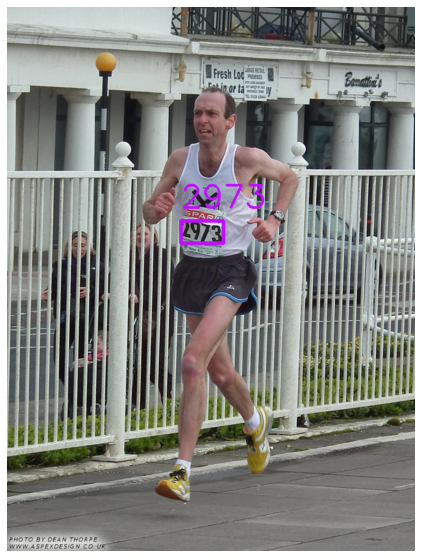

In [10]:
# Display image with predictions
img_h, img_w = img.shape[:2]
resized_img = cv.resize(img, (3*img_w, 3*img_h), interpolation=cv.INTER_CUBIC)
RGB_im = cv.cvtColor(resized_img, cv.COLOR_BGR2RGB)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(RGB_im);

### Video And Live Stream Detection Demo

In [9]:
# path for video detection
video_path = '../Data/bib_detector_demo_edit.mp4'

# choose video or live webcam stream from below:
# cap = cv.VideoCapture(video_path) # uncomment for video
# cap = cv.VideoCapture(0) # uncomment for live stream

# set ouput specifications
fourcc = cv.VideoWriter_fourcc('m','p','4','v')
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
vid_out = cv.VideoWriter('../Data/output.mp4',fourcc, 25.0, (width,height))

In [7]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # get bib prediction
    output = get_rbns(frame, single=True)

    # annotate image
    if output != None:
        for detection in output:
            frame = annotate(frame, detection, color)

    #display annotated frame
    cv.imshow('frame',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv.destroyAllWindows()